# Import Libraries

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shutil
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import ParameterGrid
from torchsummary import summary
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Global Variable

In [2]:
dataset_path  = "FULL_dataset"
train_before_path = "FULL_dataset/train"
test_before_path = "FULL_dataset/test"
dataset_split_path = "DATA"
train_dataset_path = "DATA/train"
validation_dataset_path = "DATA/validation"
test_dataset_path = "DATA/test"
num_epochs = 20

# Move model to a device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
input_shape = (3, 96, 96)
num_classes = 5

# Paramenter for HyperParameter search for all network
param_grid = {
    'learning_rate': [0.01, 0.001, 0.0001],
    'batch_size': [32, 64],
    'optimizer': ['Adam', 'SGD']
}

action_labels = {
    "0": "Do Nothing",
    "1": "Steer Left",
    "2": "Steer Right",
    "3": "Gas",
    "4": "Brake"
}

cuda


# Dataset

## Exploration of Dataset

In [3]:
"""
This code check if all images have the same dimension, same number of channes (RGB) and the 
same format
"""
results = {
    "all_same_size": True,
    "all_same_format": True,
    "all_rgb": True,
    "size": None,
    "format": None,
    "issues": []
}

subdirs = ['train', 'test']
for subdir in subdirs:
    subdir_path = os.path.join(dataset_path, subdir)
    if not os.path.isdir(subdir_path):
        print(f"Directory {subdir} not found in {dataset_path}")
        continue

    for label_folder in os.listdir(subdir_path):
        label_path = os.path.join(subdir_path, label_folder)
        if not os.path.isdir(label_path):
            continue

        for image_file in os.listdir(label_path):
            if not image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            image_path = os.path.join(label_path, image_file)
            try:
                with Image.open(image_path) as img:
                    #print(f"Checking: {image_file} | Size: {img.size} | Format: {img.format} | Mode: {img.mode}")

                    if results["size"] is None:
                        results["size"] = img.size
                    elif img.size != results["size"]:
                        results["all_same_size"] = False
                        results["issues"].append(
                            f"Different size: {image_file} ({img.size})"
                        )

                    if results["format"] is None:
                        results["format"] = img.format
                    elif img.format != results["format"]:
                        results["all_same_format"] = False
                        results["issues"].append(
                            f"Different format: {image_file} ({img.format})"
                        )

                    if img.mode != "RGB":
                        results["all_rgb"] = False
                        results["issues"].append(
                            f"Not RGB: {image_file} ({img.mode})"
                        )
            except Exception as e:
                results["issues"].append(f"Error with {image_file}: {str(e)}")

if results["issues"]:
    print("\nIssues found:")
    for issue in results["issues"]:
        print("-", issue)
else:
    print("\nAll images are consistent")

print("\nSummary:")
print(f"Uniform dimensions: {results['all_same_size']}")
print(f"Uniform format: {results['all_same_format']}")
print(f"All RGB: {results['all_rgb']}")
if results["size"]:
    print(f"Common dimensions: {results['size']}")
if results["format"]:
    print(f"Common format: {results['format']}")


All images are consistent

Summary:
Uniform dimensions: True
Uniform format: True
All RGB: True
Common dimensions: (96, 96)
Common format: PNG


In [4]:
def count_images_per_class(dataset_dir):
    """
    This function calculate the number of images for each folders of train and test
    """
    class_counts = {}

    for label_folder in os.listdir(dataset_dir):
        label_path = os.path.join(dataset_dir, label_folder)
        if os.path.isdir(label_path):
            num_images = len([
                f for f in os.listdir(label_path) 
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ])
            class_counts[label_folder] = num_images

    return class_counts


train_counts = count_images_per_class(train_before_path)
test_counts = count_images_per_class(test_before_path)

print("Train Class Counts:")
for label, count in train_counts.items():
    print(f"Class {label}: {count} images")

print("\nTest Class Counts:")
for label, count in test_counts.items():
    print(f"Class {label}: {count} images")


Train Class Counts:
Class 0: 1000 images
Class 1: 1500 images
Class 2: 1500 images
Class 3: 2000 images
Class 4: 369 images

Test Class Counts:
Class 0: 133 images
Class 1: 406 images
Class 2: 275 images
Class 3: 1896 images
Class 4: 39 images


In [5]:
train_counts = count_images_per_class(train_dataset_path)
validation_counts = count_images_per_class(validation_dataset_path)
test_counts = count_images_per_class(test_dataset_path)

print("Train Class Counts:")
for label, count in train_counts.items():
    print(f"Class {label}: {count} images")

print(" ")

print("Validation Class Counts:")
for label, count in validation_counts.items():
    print(f"Class {label}: {count} images")

print("\nTest Class Counts:")
for label, count in test_counts.items():
    print(f"Class {label}: {count} images")

Train Class Counts:
Class 0: 900 images
Class 1: 1350 images
Class 2: 1350 images
Class 3: 1800 images
Class 4: 333 images
 
Validation Class Counts:
Class 0: 100 images
Class 1: 150 images
Class 2: 150 images
Class 3: 200 images
Class 4: 36 images

Test Class Counts:
Class 0: 133 images
Class 1: 406 images
Class 2: 275 images
Class 3: 1896 images
Class 4: 39 images


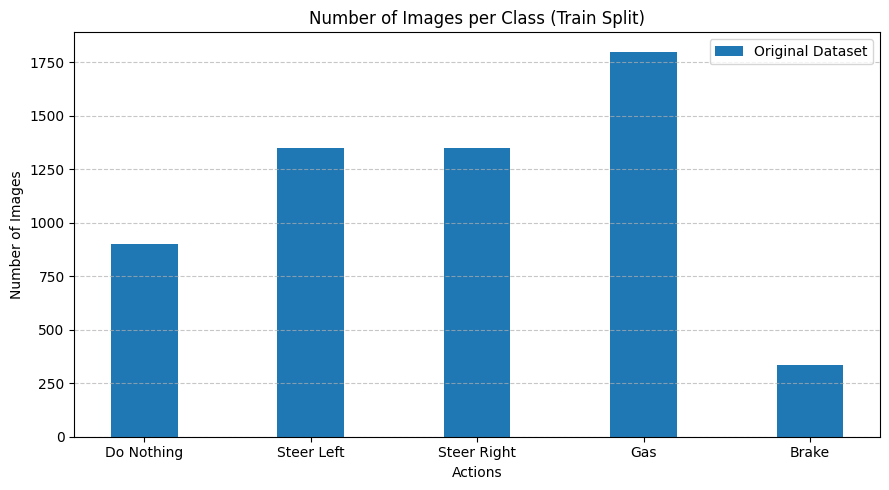

In [6]:
def enum_imgs(base_path, split="train"):
    counts = []
    for action in range(5):
        class_dir = os.path.join(base_path, split, str(action))
        counts.append(len(os.listdir(class_dir)))
    return counts

# Count images for "dataset" and "preprocessed_dataset"
dataset_counts = enum_imgs(dataset_split_path, split="train")

# Plotting
x_labels = ["Do Nothing", "Steer Left", "Steer Right", "Gas", "Brake"]
x = np.arange(len(x_labels))

plt.figure(figsize=(9, 5))

# Original dataset
plt.bar(x, dataset_counts, width=0.4, label="Original Dataset", align="center")

# Formatting the plot
plt.xticks(x, x_labels)
plt.xlabel("Actions")
plt.ylabel("Number of Images")
plt.title("Number of Images per Class (Train Split)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


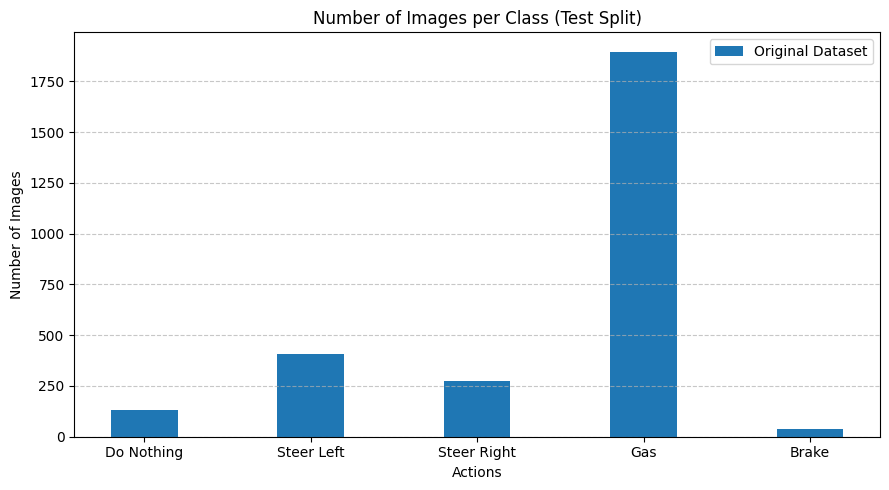

In [7]:
# Count images for "dataset" and "preprocessed_dataset"
dataset_counts = enum_imgs(dataset_split_path, split="test")

# Plotting
x_labels = ["Do Nothing", "Steer Left", "Steer Right", "Gas", "Brake"]
x = np.arange(len(x_labels))

plt.figure(figsize=(9, 5))

# Original dataset
plt.bar(x, dataset_counts, width=0.4, label="Original Dataset", align="center")

# Formatting the plot
plt.xticks(x, x_labels)
plt.xlabel("Actions")
plt.ylabel("Number of Images")
plt.title("Number of Images per Class (Test Split)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

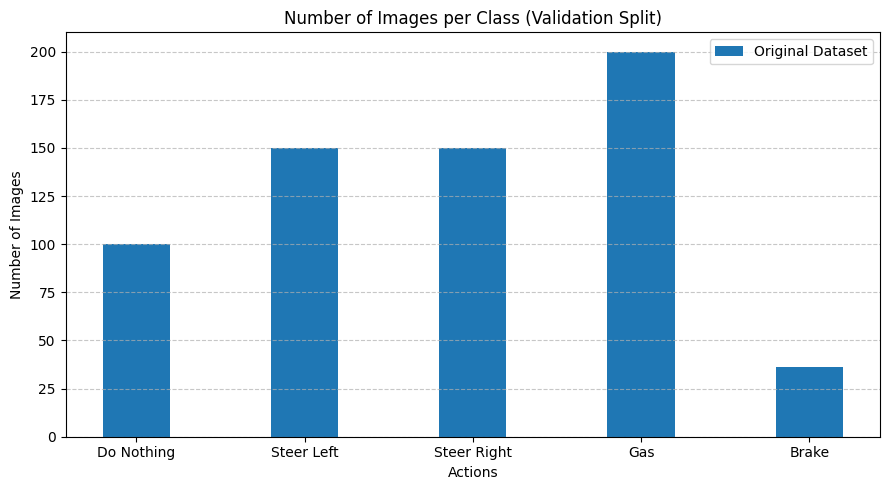

In [48]:
# Count images for "dataset" and "preprocessed_dataset"
dataset_counts = enum_imgs(dataset_split_path, split="validation")

# Plotting
x_labels = ["Do Nothing", "Steer Left", "Steer Right", "Gas", "Brake"]
x = np.arange(len(x_labels))

plt.figure(figsize=(9, 5))

# Original dataset
plt.bar(x, dataset_counts, width=0.4, label="Original Dataset", align="center")

# Formatting the plot
plt.xticks(x, x_labels)
plt.xlabel("Actions")
plt.ylabel("Number of Images")
plt.title("Number of Images per Class (Validation Split)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

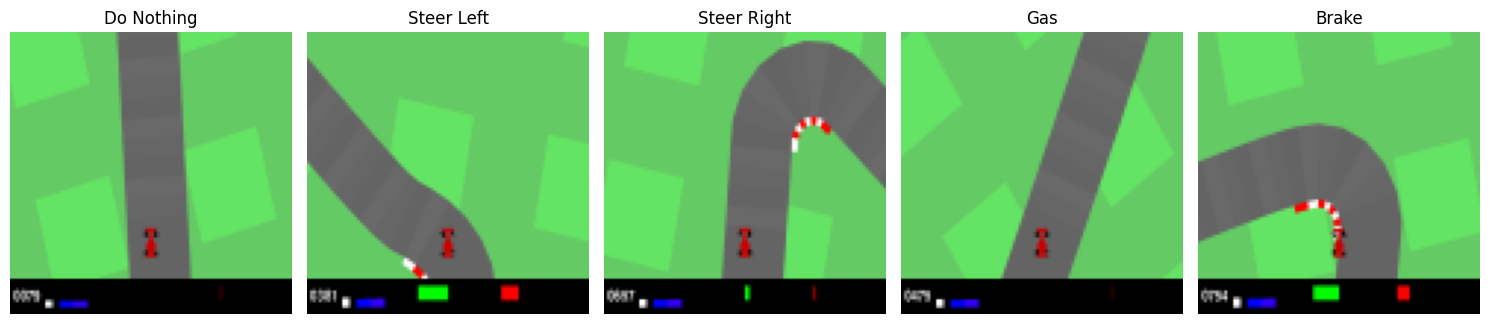

In [47]:
def plot_random_images_from_train(train_dir):
    """
    This function randomly selects and plots one image from each subfolder within the 'train' directory.
    It traverses all subdirectories of the specified 'train' folder, selects a random image from each subfolder,
    and generates a visual plot for these randomly selected images.
    This is useful for quickly visualizing a subset of the training data and verifying its structure or contents
    """

    subfolders = sorted([f for f in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, f))])

    plt.figure(figsize=(15, 5))

    for i, subfolder in enumerate(subfolders):
        folder_path = os.path.join(train_dir, subfolder)
        
        image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if not image_files:
            print(f"Nessuna immagine trovata nella cartella {subfolder}")
            continue
        
        random_image_file = np.random.choice(image_files)
        image_path = os.path.join(folder_path, random_image_file)
        
        image = Image.open(image_path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(image)
        plt.title(action_labels.get(subfolder, subfolder))
        plt.axis("off")

    plt.tight_layout()
    plt.show()
  
plot_random_images_from_train(train_dataset_path)

## Creation dataset
The following are necessary for the creation fo train and test dataset for the training of CNN, in this case I use different transformation in order to reduce the over-fitting of models

In [31]:
# Transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.RandomApply([
        transforms.RandomRotation(degrees=(-15, -15), interpolation=Image.BILINEAR),
        transforms.RandomRotation(degrees=(15, 15), interpolation=Image.BILINEAR)
    ], p=0.5), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
])

# Create datasets
train_dataset = datasets.ImageFolder(train_dataset_path, transform=transform)
validation_dataset = datasets.ImageFolder(validation_dataset_path, transform=transform_test)
test_dataset = datasets.ImageFolder(test_dataset_path, transform=transform_test)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(validation_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 5733
Number of validation samples: 636
Number of test samples: 2749


# 1 CNN
Additional in this code respect to previuse is the Dropout layer use it for reduce the overfitting during the train

In [11]:
def create_cnn_model(input_shape=(3, 96, 96), num_classes=5):
    """
    Creates a reduced CNN model for image classification using PyTorch.

    Args:
        input_shape (tuple): Shape of the input images (channels, height, width).
        num_classes (int): Number of classes for classification.

    Returns:
        nn.Module: CNN model.
    """
    class CNNModel(nn.Module):
        def __init__(self):
            super(CNNModel, self).__init__()
            
            # Convolutional Layers
            self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
            self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
            self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
            
            # Pooling Layer
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

            # Calculate the size of the flattened layer dynamically
            dummy_input = torch.zeros(1, *input_shape)
            x = self.pool(F.relu(self.conv1(dummy_input)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            flattened_size = x.numel()

            # Fully Connected Layers
            print("flattened_size:" ,flattened_size)
            self.fc1 = nn.Linear(flattened_size, 64)
            self.fc2 = nn.Linear(64, num_classes)

        def forward(self, x):
            # Convolutional layers with ReLU and Pooling
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))

            # Flatten
            x = x.view(x.size(0), -1)

            # Fully connected layers
            x = F.relu(self.fc1(x))
            x = self.fc2(x)

            return x

    return CNNModel()



model = create_cnn_model(input_shape=input_shape, num_classes=num_classes)
model = model.to(device)

# Print the summary of the model
summary(model, input_size=input_shape, device=str(device))

flattened_size: 9216
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 96, 96]             448
         MaxPool2d-2           [-1, 16, 48, 48]               0
            Conv2d-3           [-1, 32, 48, 48]           4,640
         MaxPool2d-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          18,496
         MaxPool2d-6           [-1, 64, 12, 12]               0
            Linear-7                   [-1, 64]         589,888
            Linear-8                    [-1, 5]             325
Total params: 613,797
Trainable params: 613,797
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 2.46
Params size (MB): 2.34
Estimated Total Size (MB): 4.91
----------------------------------------------------------------


# 2 CNN 
Also here I add the drop-out layer in order to reduce the overfitting

In [12]:
def create_deep_cnn_model(input_shape=(3, 96, 96), num_classes=5):
    """
    Creates a deeper CNN model for image classification using PyTorch.

    Args:
        input_shape (tuple): Shape of the input images (channels, height, width).
        num_classes (int): Number of classes for classification.

    Returns:
        nn.Module: CNN model.
    """
    class DeepCNNModel(nn.Module):
        def __init__(self):
            super(DeepCNNModel, self).__init__()
            
            # Convolutional Layers
            self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
            self.bn1 = nn.BatchNorm2d(32)
            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
            self.bn2 = nn.BatchNorm2d(64)
            self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
            self.bn3 = nn.BatchNorm2d(128)
            self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
            self.bn4 = nn.BatchNorm2d(256)
            
            # Pooling Layer
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

            # Calculate the size of the flattened layer dynamically
            dummy_input = torch.zeros(1, *input_shape)
            x = self.pool(F.relu(self.bn1(self.conv1(dummy_input))))
            x = self.pool(F.relu(self.bn2(self.conv2(x))))
            x = self.pool(F.relu(self.bn3(self.conv3(x))))
            x = self.pool(F.relu(self.bn4(self.conv4(x))))
            flattened_size = x.numel()

            # Fully Connected Layers
            print("flattened_size:" ,flattened_size)
            self.fc1 = nn.Linear(flattened_size, 1024)
            self.fc2 = nn.Linear(1024, num_classes)

        def forward(self, x):
            # Convolutional layers with ReLU and Pooling
            x = self.pool(F.relu(self.bn1(self.conv1(x))))
            x = self.pool(F.relu(self.bn2(self.conv2(x))))
            x = self.pool(F.relu(self.bn3(self.conv3(x))))
            x = self.pool(F.relu(self.bn4(self.conv4(x))))

            # Flatten
            x = x.view(x.size(0), -1)

            # Fully connected layers
            x = F.relu(self.fc1(x))
            x = self.fc2(x)

            return x

    return DeepCNNModel()

model = create_deep_cnn_model()
model = model.to(device)

# Print the summary of the model
summary(model, input_size=input_shape, device=str(device))

flattened_size: 9216
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]             896
       BatchNorm2d-2           [-1, 32, 96, 96]              64
         MaxPool2d-3           [-1, 32, 48, 48]               0
            Conv2d-4           [-1, 64, 48, 48]          18,496
       BatchNorm2d-5           [-1, 64, 48, 48]             128
         MaxPool2d-6           [-1, 64, 24, 24]               0
            Conv2d-7          [-1, 128, 24, 24]          73,856
       BatchNorm2d-8          [-1, 128, 24, 24]             256
         MaxPool2d-9          [-1, 128, 12, 12]               0
           Conv2d-10          [-1, 256, 12, 12]         295,168
      BatchNorm2d-11          [-1, 256, 12, 12]             512
        MaxPool2d-12            [-1, 256, 6, 6]               0
           Linear-13                 [-1, 1024]       9,438,208
           Linear-

# Train, HyperParameter search and Test
The follwing code are used in order to perform the train with hyperparameter search and plot of train and validation loss

In [13]:
def plot_loss(save_path, name_plot, best_model_info):

    # Plotting train loss and validation loss
    plt.subplot(2, 1, 1)
    plt.plot(best_model_info["epoch"], best_model_info["train_loss"], label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training Loss")
    
    # Plotting train accuracy
    plt.subplot(2, 1, 2)
    plt.plot(best_model_info["epoch"],  best_model_info["train_accuracy"], label="Train Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training Accuracy")

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, name_plot))
    plt.show()

In [14]:
def test_model(model, model_path, test_loader, device, show):
    if show:
        model.load_state_dict(torch.load(model_path, weights_only=False)['model_state_dict'])
        
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {accuracy:.4f}")

    # Classification Report
    if show:
        report = classification_report(all_labels, all_preds, target_names=test_loader.dataset.classes)
    else:
        report = classification_report(all_labels, all_preds, target_names=test_loader.dataset.classes, output_dict=True)
    if show:
        print("Classification Report:\n", report)

    # Confusion Matrix
    if show:
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()

    return accuracy, report

In [15]:
def train_model(model, train_loader, optimizer, criterion, device, num_epochs):
    model.to(device)

    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        print(f"Epoch {epoch + 1}/{num_epochs}")

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()

            train_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss /= len(train_loader)
        train_accuracy = correct / total

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    return train_losses, train_accuracies

In [16]:
def hyperparameter_search(num, train_data, validation_data, param_grid, save_path, name_model, num_epochs, device):
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    best_params = None
    best_accuracy = 0
    best_f1_score = 0
    best_recall = 0
    best_precision = 0
    best_model_info = None

    results_file_path = os.path.join(save_path, f"{name_model}_results.txt")
    with open(results_file_path, "w") as results_file:
        for params in ParameterGrid(param_grid):
            print(f"Testing params: {params}")

            if num == 1:
                model = create_cnn_model()
            else:
                model = create_deep_cnn_model()

            # Initialize optimizer and loss function
            optimizer = getattr(torch.optim, params['optimizer'])(model.parameters(), lr=params['learning_rate'])
            criterion = nn.CrossEntropyLoss()

            # Create DataLoader
            train_loader = DataLoader(train_data, batch_size=params['batch_size'], shuffle=True)
            validation_loader = DataLoader(validation_data, batch_size=64, shuffle=False)

            # Train model and collect losses and predictions
            train_losses, train_accuracies = train_model(model, train_loader, optimizer, criterion, device, num_epochs)

            # Evaluate model on validation set
            model_path = None
            accuracy, classification_metrics = test_model(model, model_path, validation_loader, device, show=False)

            # Compute average precision, recall, and F1-score across all classes
            precision_avg = classification_metrics['weighted avg']['precision']
            recall_avg = classification_metrics['weighted avg']['recall']
            f1_score_avg = classification_metrics['weighted avg']['f1-score']

            # Save results to file
            results_file.write(f"MODEL BATCH_SIZE={params['batch_size']} LEARNING_RATE={params['learning_rate']} OPTIMIZER={params['optimizer']}\n")
            results_file.write(f"ACCURACY={accuracy} PRECISION={precision_avg} RECALL={recall_avg} F1_SCORE={f1_score_avg}\n\n")

            if accuracy > best_accuracy and precision_avg > best_precision:
                best_accuracy = accuracy
                best_f1_score = f1_score_avg
                best_precision = precision_avg
                best_recall = recall_avg
                best_params = params
                best_model_info = {
                    "epoch": list(range(1, num_epochs + 1)),
                    "train_loss": train_losses,
                    "train_accuracy": train_accuracies,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "hyperparameters": params
                }

                # Save the best model
                torch.save(best_model_info, os.path.join(save_path, name_model))

    print(f"Best Params: {best_params}, Best Accuracy: {best_accuracy}, Best Average Precision: {best_precision}")
    return best_params, best_model_info

# Train and Test of 1 CNN

In [32]:
name_plot="TRAIN_VAL_LOSS_1_CNN.png"
save_path="SAVE/PREPROCESSED"
name_model="1_CNN.pth"
num = 1
best_params, best_model_info = hyperparameter_search(num, train_dataset, validation_dataset,  param_grid, save_path, name_model, num_epochs, device)

print(f"Best hyperparameters: {best_params}")

Testing params: {'batch_size': 32, 'learning_rate': 0.01, 'optimizer': 'Adam'}
flattened_size: 9216
Epoch 1/20
Train Loss: 1.2138, Train Accuracy: 0.5611
Epoch 2/20
Train Loss: 1.1184, Train Accuracy: 0.5934
Epoch 3/20
Train Loss: 1.0742, Train Accuracy: 0.6035
Epoch 4/20
Train Loss: 1.0447, Train Accuracy: 0.6154
Epoch 5/20
Train Loss: 0.9972, Train Accuracy: 0.6316
Epoch 6/20
Train Loss: 0.9733, Train Accuracy: 0.6393
Epoch 7/20
Train Loss: 0.9452, Train Accuracy: 0.6543
Epoch 8/20
Train Loss: 0.9277, Train Accuracy: 0.6565
Epoch 9/20
Train Loss: 0.9037, Train Accuracy: 0.6717
Epoch 10/20
Train Loss: 0.8714, Train Accuracy: 0.6763
Epoch 11/20
Train Loss: 0.8541, Train Accuracy: 0.6780
Epoch 12/20
Train Loss: 0.8354, Train Accuracy: 0.6811
Epoch 13/20
Train Loss: 0.8153, Train Accuracy: 0.6928
Epoch 14/20
Train Loss: 0.7987, Train Accuracy: 0.7017
Epoch 15/20
Train Loss: 0.7999, Train Accuracy: 0.6977
Epoch 16/20
Train Loss: 0.7661, Train Accuracy: 0.7113
Epoch 17/20
Train Loss: 0.758

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Train Loss: 1.5233, Train Accuracy: 0.3028
Epoch 2/20
Train Loss: 1.4877, Train Accuracy: 0.3138
Epoch 3/20
Train Loss: 1.4122, Train Accuracy: 0.4322
Epoch 4/20
Train Loss: 1.2394, Train Accuracy: 0.5456
Epoch 5/20
Train Loss: 1.1923, Train Accuracy: 0.5585
Epoch 6/20
Train Loss: 1.1785, Train Accuracy: 0.5618
Epoch 7/20
Train Loss: 1.1628, Train Accuracy: 0.5645
Epoch 8/20
Train Loss: 1.1550, Train Accuracy: 0.5697
Epoch 9/20
Train Loss: 1.1467, Train Accuracy: 0.5709
Epoch 10/20
Train Loss: 1.1379, Train Accuracy: 0.5777
Epoch 11/20
Train Loss: 1.1317, Train Accuracy: 0.5821
Epoch 12/20
Train Loss: 1.1250, Train Accuracy: 0.5774
Epoch 13/20
Train Loss: 1.1208, Train Accuracy: 0.5822
Epoch 14/20
Train Loss: 1.1186, Train Accuracy: 0.5859
Epoch 15/20
Train Loss: 1.1127, Train Accuracy: 0.5857
Epoch 16/20
Train Loss: 1.1106, Train Accuracy: 0.5877
Epoch 17/20
Train Loss: 1.1043, Train Accuracy: 0.5892
Epoch 18/20
Train Loss: 1.1010, Train Accuracy: 0.5955
Epoch 19/20
Train Loss: 1.1053

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Train Loss: 1.5814, Train Accuracy: 0.3140
Epoch 2/20
Train Loss: 1.5515, Train Accuracy: 0.3140
Epoch 3/20
Train Loss: 1.5256, Train Accuracy: 0.3140
Epoch 4/20
Train Loss: 1.5098, Train Accuracy: 0.3140
Epoch 5/20
Train Loss: 1.5014, Train Accuracy: 0.3140
Epoch 6/20
Train Loss: 1.4960, Train Accuracy: 0.3140
Epoch 7/20
Train Loss: 1.4919, Train Accuracy: 0.3140
Epoch 8/20
Train Loss: 1.4896, Train Accuracy: 0.3140
Epoch 9/20
Train Loss: 1.4860, Train Accuracy: 0.3140
Epoch 10/20
Train Loss: 1.4799, Train Accuracy: 0.3140
Epoch 11/20
Train Loss: 1.4747, Train Accuracy: 0.3140
Epoch 12/20
Train Loss: 1.4687, Train Accuracy: 0.3140
Epoch 13/20
Train Loss: 1.4587, Train Accuracy: 0.3140
Epoch 14/20
Train Loss: 1.4477, Train Accuracy: 0.3199
Epoch 15/20
Train Loss: 1.4310, Train Accuracy: 0.3715
Epoch 16/20
Train Loss: 1.4144, Train Accuracy: 0.4807
Epoch 17/20
Train Loss: 1.3891, Train Accuracy: 0.5296
Epoch 18/20
Train Loss: 1.3612, Train Accuracy: 0.5472
Epoch 19/20
Train Loss: 1.3315

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Train Loss: 1.3585, Train Accuracy: 0.4450
Epoch 2/20
Train Loss: 1.1826, Train Accuracy: 0.5606
Epoch 3/20
Train Loss: 1.1422, Train Accuracy: 0.5784
Epoch 4/20
Train Loss: 1.1160, Train Accuracy: 0.5927
Epoch 5/20
Train Loss: 1.0969, Train Accuracy: 0.5997
Epoch 6/20
Train Loss: 1.0779, Train Accuracy: 0.6061
Epoch 7/20
Train Loss: 1.0635, Train Accuracy: 0.6126
Epoch 8/20
Train Loss: 1.0503, Train Accuracy: 0.6119
Epoch 9/20
Train Loss: 1.0338, Train Accuracy: 0.6168
Epoch 10/20
Train Loss: 1.0271, Train Accuracy: 0.6238
Epoch 11/20
Train Loss: 1.0208, Train Accuracy: 0.6262
Epoch 12/20
Train Loss: 1.0087, Train Accuracy: 0.6320
Epoch 13/20
Train Loss: 1.0019, Train Accuracy: 0.6278
Epoch 14/20
Train Loss: 0.9942, Train Accuracy: 0.6288
Epoch 15/20
Train Loss: 0.9851, Train Accuracy: 0.6325
Epoch 16/20
Train Loss: 0.9698, Train Accuracy: 0.6412
Epoch 17/20
Train Loss: 0.9655, Train Accuracy: 0.6415
Epoch 18/20
Train Loss: 0.9580, Train Accuracy: 0.6478
Epoch 19/20
Train Loss: 0.9528

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Train Loss: 1.6073, Train Accuracy: 0.2355
Epoch 2/20
Train Loss: 1.6045, Train Accuracy: 0.2355
Epoch 3/20
Train Loss: 1.6016, Train Accuracy: 0.2355
Epoch 4/20
Train Loss: 1.5987, Train Accuracy: 0.2355
Epoch 5/20
Train Loss: 1.5960, Train Accuracy: 0.2355
Epoch 6/20
Train Loss: 1.5934, Train Accuracy: 0.2358
Epoch 7/20
Train Loss: 1.5905, Train Accuracy: 0.2597
Epoch 8/20
Train Loss: 1.5882, Train Accuracy: 0.2871
Epoch 9/20
Train Loss: 1.5860, Train Accuracy: 0.2958
Epoch 10/20
Train Loss: 1.5833, Train Accuracy: 0.3216
Epoch 11/20
Train Loss: 1.5807, Train Accuracy: 0.3143
Epoch 12/20
Train Loss: 1.5781, Train Accuracy: 0.3140
Epoch 13/20
Train Loss: 1.5756, Train Accuracy: 0.3140
Epoch 14/20
Train Loss: 1.5738, Train Accuracy: 0.3140
Epoch 15/20
Train Loss: 1.5715, Train Accuracy: 0.3140
Epoch 16/20
Train Loss: 1.5680, Train Accuracy: 0.3140
Epoch 17/20
Train Loss: 1.5658, Train Accuracy: 0.3140
Epoch 18/20
Train Loss: 1.5634, Train Accuracy: 0.3140
Epoch 19/20
Train Loss: 1.5621

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Train Loss: 1.2395, Train Accuracy: 0.5407
Epoch 2/20
Train Loss: 1.1014, Train Accuracy: 0.5952
Epoch 3/20
Train Loss: 1.0514, Train Accuracy: 0.6142
Epoch 4/20
Train Loss: 1.0132, Train Accuracy: 0.6318
Epoch 5/20
Train Loss: 0.9717, Train Accuracy: 0.6433
Epoch 6/20
Train Loss: 0.9319, Train Accuracy: 0.6468
Epoch 7/20
Train Loss: 0.8840, Train Accuracy: 0.6581
Epoch 8/20
Train Loss: 0.8432, Train Accuracy: 0.6768
Epoch 9/20
Train Loss: 0.7983, Train Accuracy: 0.6867
Epoch 10/20
Train Loss: 0.7602, Train Accuracy: 0.7036
Epoch 11/20
Train Loss: 0.7312, Train Accuracy: 0.7127
Epoch 12/20
Train Loss: 0.7115, Train Accuracy: 0.7232
Epoch 13/20
Train Loss: 0.6716, Train Accuracy: 0.7359
Epoch 14/20
Train Loss: 0.6370, Train Accuracy: 0.7518
Epoch 15/20
Train Loss: 0.6110, Train Accuracy: 0.7565
Epoch 16/20
Train Loss: 0.5992, Train Accuracy: 0.7635
Epoch 17/20
Train Loss: 0.5808, Train Accuracy: 0.7682
Epoch 18/20
Train Loss: 0.5654, Train Accuracy: 0.7786
Epoch 19/20
Train Loss: 0.5379

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Train Loss: 1.5702, Train Accuracy: 0.2766
Epoch 2/20
Train Loss: 1.4997, Train Accuracy: 0.3140
Epoch 3/20
Train Loss: 1.4903, Train Accuracy: 0.3140
Epoch 4/20
Train Loss: 1.4671, Train Accuracy: 0.3264
Epoch 5/20
Train Loss: 1.3700, Train Accuracy: 0.4800
Epoch 6/20
Train Loss: 1.2415, Train Accuracy: 0.5463
Epoch 7/20
Train Loss: 1.2015, Train Accuracy: 0.5505
Epoch 8/20
Train Loss: 1.1841, Train Accuracy: 0.5599
Epoch 9/20
Train Loss: 1.1761, Train Accuracy: 0.5632
Epoch 10/20
Train Loss: 1.1664, Train Accuracy: 0.5681
Epoch 11/20
Train Loss: 1.1591, Train Accuracy: 0.5678
Epoch 12/20
Train Loss: 1.1523, Train Accuracy: 0.5720
Epoch 13/20
Train Loss: 1.1484, Train Accuracy: 0.5782
Epoch 14/20
Train Loss: 1.1443, Train Accuracy: 0.5737
Epoch 15/20
Train Loss: 1.1398, Train Accuracy: 0.5788
Epoch 16/20
Train Loss: 1.1337, Train Accuracy: 0.5772
Epoch 17/20
Train Loss: 1.1300, Train Accuracy: 0.5831
Epoch 18/20
Train Loss: 1.1250, Train Accuracy: 0.5849
Epoch 19/20
Train Loss: 1.1250

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Train Loss: 1.2456, Train Accuracy: 0.5221
Epoch 2/20
Train Loss: 1.0937, Train Accuracy: 0.5995
Epoch 3/20
Train Loss: 1.0514, Train Accuracy: 0.6103
Epoch 4/20
Train Loss: 1.0073, Train Accuracy: 0.6245
Epoch 5/20
Train Loss: 0.9813, Train Accuracy: 0.6426
Epoch 6/20
Train Loss: 0.9470, Train Accuracy: 0.6489
Epoch 7/20
Train Loss: 0.9179, Train Accuracy: 0.6618
Epoch 8/20
Train Loss: 0.8846, Train Accuracy: 0.6757
Epoch 9/20
Train Loss: 0.8386, Train Accuracy: 0.6951
Epoch 10/20
Train Loss: 0.8189, Train Accuracy: 0.7036
Epoch 11/20
Train Loss: 0.7870, Train Accuracy: 0.7136
Epoch 12/20
Train Loss: 0.7475, Train Accuracy: 0.7265
Epoch 13/20
Train Loss: 0.6953, Train Accuracy: 0.7481
Epoch 14/20
Train Loss: 0.6583, Train Accuracy: 0.7616
Epoch 15/20
Train Loss: 0.6315, Train Accuracy: 0.7696
Epoch 16/20
Train Loss: 0.5915, Train Accuracy: 0.7855
Epoch 17/20
Train Loss: 0.5489, Train Accuracy: 0.8020
Epoch 18/20
Train Loss: 0.5218, Train Accuracy: 0.8099
Epoch 19/20
Train Loss: 0.4903

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Train Loss: 1.6075, Train Accuracy: 0.1966
Epoch 2/20
Train Loss: 1.5937, Train Accuracy: 0.2355
Epoch 3/20
Train Loss: 1.5788, Train Accuracy: 0.2529
Epoch 4/20
Train Loss: 1.5639, Train Accuracy: 0.3128
Epoch 5/20
Train Loss: 1.5487, Train Accuracy: 0.3140
Epoch 6/20
Train Loss: 1.5345, Train Accuracy: 0.3140
Epoch 7/20
Train Loss: 1.5226, Train Accuracy: 0.3140
Epoch 8/20
Train Loss: 1.5125, Train Accuracy: 0.3140
Epoch 9/20
Train Loss: 1.5066, Train Accuracy: 0.3140
Epoch 10/20
Train Loss: 1.5031, Train Accuracy: 0.3140
Epoch 11/20
Train Loss: 1.5002, Train Accuracy: 0.3140
Epoch 12/20
Train Loss: 1.4976, Train Accuracy: 0.3140
Epoch 13/20
Train Loss: 1.4955, Train Accuracy: 0.3140
Epoch 14/20
Train Loss: 1.4952, Train Accuracy: 0.3140
Epoch 15/20
Train Loss: 1.4933, Train Accuracy: 0.3140
Epoch 16/20
Train Loss: 1.4920, Train Accuracy: 0.3140
Epoch 17/20
Train Loss: 1.4908, Train Accuracy: 0.3140
Epoch 18/20
Train Loss: 1.4893, Train Accuracy: 0.3140
Epoch 19/20
Train Loss: 1.4878

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Train Loss: 1.4408, Train Accuracy: 0.4115
Epoch 2/20
Train Loss: 1.2052, Train Accuracy: 0.5481
Epoch 3/20
Train Loss: 1.1643, Train Accuracy: 0.5651
Epoch 4/20
Train Loss: 1.1391, Train Accuracy: 0.5821
Epoch 5/20
Train Loss: 1.1202, Train Accuracy: 0.5868
Epoch 6/20
Train Loss: 1.1094, Train Accuracy: 0.5936
Epoch 7/20
Train Loss: 1.0971, Train Accuracy: 0.5999
Epoch 8/20
Train Loss: 1.0864, Train Accuracy: 0.6000
Epoch 9/20
Train Loss: 1.0735, Train Accuracy: 0.6060
Epoch 10/20
Train Loss: 1.0664, Train Accuracy: 0.6046
Epoch 11/20
Train Loss: 1.0570, Train Accuracy: 0.6095
Epoch 12/20
Train Loss: 1.0457, Train Accuracy: 0.6157
Epoch 13/20
Train Loss: 1.0404, Train Accuracy: 0.6183
Epoch 14/20
Train Loss: 1.0286, Train Accuracy: 0.6180
Epoch 15/20
Train Loss: 1.0199, Train Accuracy: 0.6239
Epoch 16/20
Train Loss: 1.0143, Train Accuracy: 0.6217
Epoch 17/20
Train Loss: 1.0123, Train Accuracy: 0.6272
Epoch 18/20
Train Loss: 0.9952, Train Accuracy: 0.6334
Epoch 19/20
Train Loss: 0.9978

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Train Loss: 1.6057, Train Accuracy: 0.3140
Epoch 2/20
Train Loss: 1.6046, Train Accuracy: 0.3140
Epoch 3/20
Train Loss: 1.6034, Train Accuracy: 0.3140
Epoch 4/20
Train Loss: 1.6022, Train Accuracy: 0.3140
Epoch 5/20
Train Loss: 1.6012, Train Accuracy: 0.3140
Epoch 6/20
Train Loss: 1.6001, Train Accuracy: 0.3140
Epoch 7/20
Train Loss: 1.5991, Train Accuracy: 0.3140
Epoch 8/20
Train Loss: 1.5980, Train Accuracy: 0.3140
Epoch 9/20
Train Loss: 1.5970, Train Accuracy: 0.3140
Epoch 10/20
Train Loss: 1.5960, Train Accuracy: 0.3140
Epoch 11/20
Train Loss: 1.5950, Train Accuracy: 0.3140
Epoch 12/20
Train Loss: 1.5941, Train Accuracy: 0.3140
Epoch 13/20
Train Loss: 1.5931, Train Accuracy: 0.3140
Epoch 14/20
Train Loss: 1.5922, Train Accuracy: 0.3140
Epoch 15/20
Train Loss: 1.5913, Train Accuracy: 0.3140
Epoch 16/20
Train Loss: 1.5905, Train Accuracy: 0.3140
Epoch 17/20
Train Loss: 1.5895, Train Accuracy: 0.3140
Epoch 18/20
Train Loss: 1.5887, Train Accuracy: 0.3140
Epoch 19/20
Train Loss: 1.5878

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

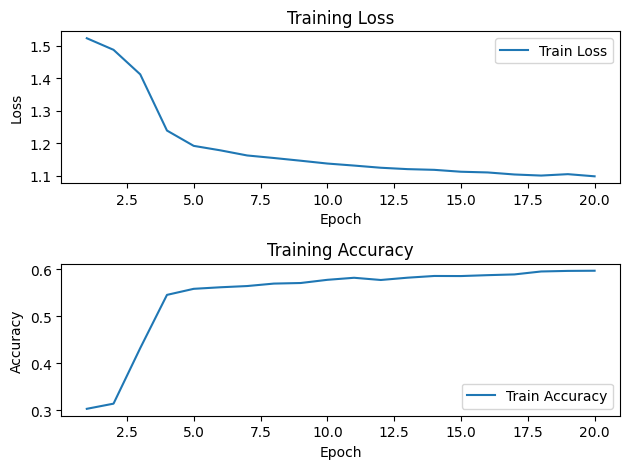

In [33]:
plot_loss(save_path, name_plot, best_model_info)

flattened_size: 9216
Test Accuracy: 0.6017
Classification Report:
               precision    recall  f1-score   support

           0       0.13      0.49      0.20       133
           1       0.43      0.61      0.50       406
           2       0.52      0.23      0.31       275
           3       0.84      0.67      0.75      1896
           4       0.07      0.05      0.06        39

    accuracy                           0.60      2749
   macro avg       0.40      0.41      0.37      2749
weighted avg       0.70      0.60      0.63      2749



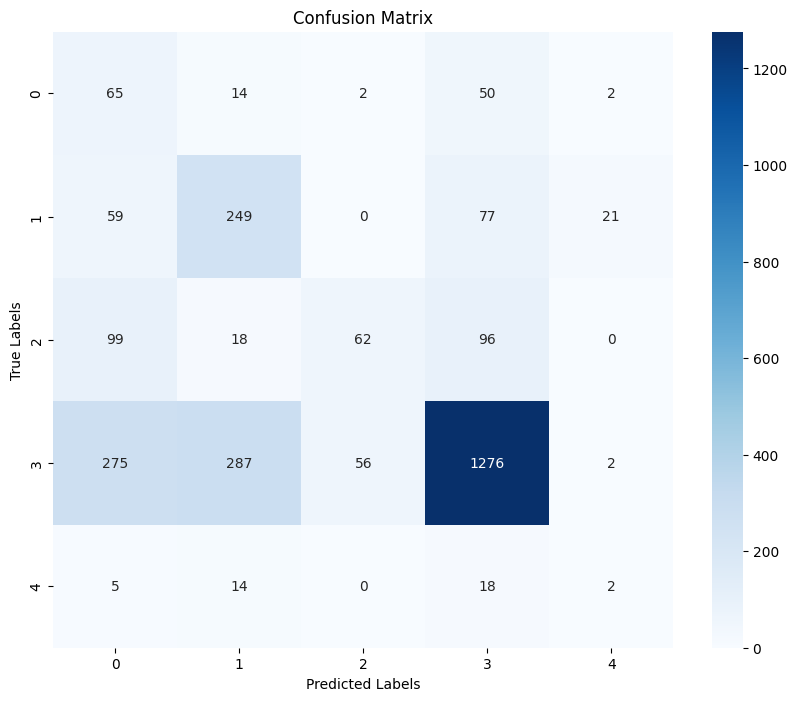

In [34]:

model_path = "SAVE/PREPROCESSED/1_CNN.pth"
model = create_cnn_model()
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
accuracy, report = test_model(model, model_path, test_loader, device, show=True)

# Train and Test of 2 CNN

In [41]:
name_plot="TRAIN_VAL_LOSS_2_CNN.png"
save_path="SAVE/PREPROCESSED"
name_model="2_CNN.pth"
num = 2
best_params, best_model_info = hyperparameter_search(num, train_dataset, validation_dataset,  param_grid, save_path, name_model, num_epochs, device)

print(f"Best hyperparameters: {best_params}")

Testing params: {'batch_size': 32, 'learning_rate': 0.01, 'optimizer': 'Adam'}
flattened_size: 9216
Epoch 1/20
Train Loss: 15.7654, Train Accuracy: 0.2986
Epoch 2/20
Train Loss: 1.2021, Train Accuracy: 0.5542
Epoch 3/20
Train Loss: 1.1383, Train Accuracy: 0.5768
Epoch 4/20
Train Loss: 1.1094, Train Accuracy: 0.5927
Epoch 5/20
Train Loss: 1.0864, Train Accuracy: 0.6039
Epoch 6/20
Train Loss: 1.0662, Train Accuracy: 0.6091
Epoch 7/20
Train Loss: 1.0376, Train Accuracy: 0.6175
Epoch 8/20
Train Loss: 1.0251, Train Accuracy: 0.6175
Epoch 9/20
Train Loss: 1.0132, Train Accuracy: 0.6288
Epoch 10/20
Train Loss: 0.9927, Train Accuracy: 0.6365
Epoch 11/20
Train Loss: 0.9886, Train Accuracy: 0.6367
Epoch 12/20
Train Loss: 0.9811, Train Accuracy: 0.6361
Epoch 13/20
Train Loss: 0.9785, Train Accuracy: 0.6381
Epoch 14/20
Train Loss: 0.9604, Train Accuracy: 0.6473
Epoch 15/20
Train Loss: 0.9584, Train Accuracy: 0.6471
Epoch 16/20
Train Loss: 0.9504, Train Accuracy: 0.6522
Epoch 17/20
Train Loss: 0.93

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Epoch 1/20
Train Loss: 1.2753, Train Accuracy: 0.5186
Epoch 2/20
Train Loss: 1.1552, Train Accuracy: 0.5746
Epoch 3/20
Train Loss: 1.1082, Train Accuracy: 0.5875
Epoch 4/20
Train Loss: 1.0747, Train Accuracy: 0.6044
Epoch 5/20
Train Loss: 1.0508, Train Accuracy: 0.6175
Epoch 6/20
Train Loss: 1.0252, Train Accuracy: 0.6225
Epoch 7/20
Train Loss: 1.0150, Train Accuracy: 0.6313
Epoch 8/20
Train Loss: 0.9899, Train Accuracy: 0.6353
Epoch 9/20
Train Loss: 0.9660, Train Accuracy: 0.6478
Epoch 10/20
Train Loss: 0.9538, Train Accuracy: 0.6496
Epoch 11/20
Train Loss: 0.9405, Train Accuracy: 0.6646
Epoch 12/20
Train Loss: 0.9255, Train Accuracy: 0.6670
Epoch 13/20
Train Loss: 0.9111, Train Accuracy: 0.6719
Epoch 14/20
Train Loss: 0.8996, Train Accuracy: 0.6731
Epoch 15/20
Train Loss: 0.8782, Train Accuracy: 0.6866
Epoch 16/20
Train Loss: 0.8666, Train Accuracy: 0.6911
Epoch 17/20
Train Loss: 0.8569, Train Accuracy: 0.6953
Epoch 18/20
Train Loss: 0.8413, Train Accuracy: 0.7024
Epoch 19/20
Train L

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Train Loss: 2.0900, Train Accuracy: 0.4582
Epoch 2/20
Train Loss: 1.1547, Train Accuracy: 0.5737
Epoch 3/20
Train Loss: 1.1033, Train Accuracy: 0.5953
Epoch 4/20
Train Loss: 1.0551, Train Accuracy: 0.6124
Epoch 5/20
Train Loss: 1.0158, Train Accuracy: 0.6295
Epoch 6/20
Train Loss: 0.9613, Train Accuracy: 0.6419
Epoch 7/20
Train Loss: 0.9263, Train Accuracy: 0.6618
Epoch 8/20
Train Loss: 0.8660, Train Accuracy: 0.6864
Epoch 9/20
Train Loss: 0.8305, Train Accuracy: 0.7064
Epoch 10/20
Train Loss: 0.7799, Train Accuracy: 0.7167
Epoch 11/20
Train Loss: 0.7451, Train Accuracy: 0.7352
Epoch 12/20
Train Loss: 0.6872, Train Accuracy: 0.7532
Epoch 13/20
Train Loss: 0.6394, Train Accuracy: 0.7640
Epoch 14/20
Train Loss: 0.6001, Train Accuracy: 0.7781
Epoch 15/20
Train Loss: 0.5690, Train Accuracy: 0.7914
Epoch 16/20
Train Loss: 0.5234, Train Accuracy: 0.8092
Epoch 17/20
Train Loss: 0.4780, Train Accuracy: 0.8245
Epoch 18/20
Train Loss: 0.4538, Train Accuracy: 0.8350
Epoch 19/20
Train Loss: 0.4129

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Train Loss: 1.4601, Train Accuracy: 0.3963
Epoch 2/20
Train Loss: 1.3490, Train Accuracy: 0.5081
Epoch 3/20
Train Loss: 1.2904, Train Accuracy: 0.5261
Epoch 4/20
Train Loss: 1.2566, Train Accuracy: 0.5364
Epoch 5/20
Train Loss: 1.2333, Train Accuracy: 0.5446
Epoch 6/20
Train Loss: 1.2143, Train Accuracy: 0.5510
Epoch 7/20
Train Loss: 1.2039, Train Accuracy: 0.5554
Epoch 8/20
Train Loss: 1.1873, Train Accuracy: 0.5597
Epoch 9/20
Train Loss: 1.1769, Train Accuracy: 0.5589
Epoch 10/20
Train Loss: 1.1658, Train Accuracy: 0.5674
Epoch 11/20
Train Loss: 1.1613, Train Accuracy: 0.5686
Epoch 12/20
Train Loss: 1.1512, Train Accuracy: 0.5739
Epoch 13/20
Train Loss: 1.1424, Train Accuracy: 0.5758
Epoch 14/20
Train Loss: 1.1375, Train Accuracy: 0.5774
Epoch 15/20
Train Loss: 1.1312, Train Accuracy: 0.5805
Epoch 16/20
Train Loss: 1.1256, Train Accuracy: 0.5843
Epoch 17/20
Train Loss: 1.1206, Train Accuracy: 0.5850
Epoch 18/20
Train Loss: 1.1179, Train Accuracy: 0.5866
Epoch 19/20
Train Loss: 1.1101

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Train Loss: 1.2215, Train Accuracy: 0.5454
Epoch 2/20
Train Loss: 1.0798, Train Accuracy: 0.6051
Epoch 3/20
Train Loss: 1.0286, Train Accuracy: 0.6203
Epoch 4/20
Train Loss: 0.9689, Train Accuracy: 0.6438
Epoch 5/20
Train Loss: 0.9263, Train Accuracy: 0.6634
Epoch 6/20
Train Loss: 0.8684, Train Accuracy: 0.6913
Epoch 7/20
Train Loss: 0.8191, Train Accuracy: 0.7143
Epoch 8/20
Train Loss: 0.7676, Train Accuracy: 0.7261
Epoch 9/20
Train Loss: 0.7417, Train Accuracy: 0.7382
Epoch 10/20
Train Loss: 0.6586, Train Accuracy: 0.7729
Epoch 11/20
Train Loss: 0.6204, Train Accuracy: 0.7905
Epoch 12/20
Train Loss: 0.5681, Train Accuracy: 0.8036
Epoch 13/20
Train Loss: 0.5245, Train Accuracy: 0.8114
Epoch 14/20
Train Loss: 0.4749, Train Accuracy: 0.8381
Epoch 15/20
Train Loss: 0.4392, Train Accuracy: 0.8495
Epoch 16/20
Train Loss: 0.3993, Train Accuracy: 0.8624
Epoch 17/20
Train Loss: 0.3735, Train Accuracy: 0.8741
Epoch 18/20
Train Loss: 0.3402, Train Accuracy: 0.8861
Epoch 19/20
Train Loss: 0.3172

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Train Loss: 1.6043, Train Accuracy: 0.2184
Epoch 2/20
Train Loss: 1.5337, Train Accuracy: 0.3128
Epoch 3/20
Train Loss: 1.4969, Train Accuracy: 0.3905
Epoch 4/20
Train Loss: 1.4742, Train Accuracy: 0.4101
Epoch 5/20
Train Loss: 1.4571, Train Accuracy: 0.4146
Epoch 6/20
Train Loss: 1.4407, Train Accuracy: 0.4331
Epoch 7/20
Train Loss: 1.4309, Train Accuracy: 0.4486
Epoch 8/20
Train Loss: 1.4184, Train Accuracy: 0.4624
Epoch 9/20
Train Loss: 1.4072, Train Accuracy: 0.4725
Epoch 10/20
Train Loss: 1.3987, Train Accuracy: 0.4874
Epoch 11/20
Train Loss: 1.3855, Train Accuracy: 0.5025
Epoch 12/20
Train Loss: 1.3785, Train Accuracy: 0.5027
Epoch 13/20
Train Loss: 1.3686, Train Accuracy: 0.5102
Epoch 14/20
Train Loss: 1.3577, Train Accuracy: 0.5144
Epoch 15/20
Train Loss: 1.3517, Train Accuracy: 0.5177
Epoch 16/20
Train Loss: 1.3462, Train Accuracy: 0.5151
Epoch 17/20
Train Loss: 1.3384, Train Accuracy: 0.5208
Epoch 18/20
Train Loss: 1.3329, Train Accuracy: 0.5221
Epoch 19/20
Train Loss: 1.3268

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Train Loss: 24.3630, Train Accuracy: 0.3947
Epoch 2/20
Train Loss: 1.2374, Train Accuracy: 0.5437
Epoch 3/20
Train Loss: 1.1927, Train Accuracy: 0.5542
Epoch 4/20
Train Loss: 1.1416, Train Accuracy: 0.5768
Epoch 5/20
Train Loss: 1.1191, Train Accuracy: 0.5883
Epoch 6/20
Train Loss: 1.1105, Train Accuracy: 0.5936
Epoch 7/20
Train Loss: 1.0884, Train Accuracy: 0.6023
Epoch 8/20
Train Loss: 1.0609, Train Accuracy: 0.6095
Epoch 9/20
Train Loss: 1.0302, Train Accuracy: 0.6161
Epoch 10/20
Train Loss: 1.0008, Train Accuracy: 0.6334
Epoch 11/20
Train Loss: 0.9739, Train Accuracy: 0.6442
Epoch 12/20
Train Loss: 0.9436, Train Accuracy: 0.6529
Epoch 13/20
Train Loss: 0.9144, Train Accuracy: 0.6644
Epoch 14/20
Train Loss: 0.8883, Train Accuracy: 0.6773
Epoch 15/20
Train Loss: 0.8599, Train Accuracy: 0.6897
Epoch 16/20
Train Loss: 0.8345, Train Accuracy: 0.6974
Epoch 17/20
Train Loss: 0.8038, Train Accuracy: 0.7111
Epoch 18/20
Train Loss: 0.7871, Train Accuracy: 0.7157
Epoch 19/20
Train Loss: 0.757

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Train Loss: 1.3062, Train Accuracy: 0.5043
Epoch 2/20
Train Loss: 1.1770, Train Accuracy: 0.5594
Epoch 3/20
Train Loss: 1.1331, Train Accuracy: 0.5758
Epoch 4/20
Train Loss: 1.1084, Train Accuracy: 0.5856
Epoch 5/20
Train Loss: 1.0814, Train Accuracy: 0.6000
Epoch 6/20
Train Loss: 1.0642, Train Accuracy: 0.6065
Epoch 7/20
Train Loss: 1.0496, Train Accuracy: 0.6124
Epoch 8/20
Train Loss: 1.0331, Train Accuracy: 0.6157
Epoch 9/20
Train Loss: 1.0197, Train Accuracy: 0.6262
Epoch 10/20
Train Loss: 1.0070, Train Accuracy: 0.6318
Epoch 11/20
Train Loss: 0.9959, Train Accuracy: 0.6358
Epoch 12/20
Train Loss: 0.9811, Train Accuracy: 0.6421
Epoch 13/20
Train Loss: 0.9720, Train Accuracy: 0.6463
Epoch 14/20
Train Loss: 0.9579, Train Accuracy: 0.6499
Epoch 15/20
Train Loss: 0.9504, Train Accuracy: 0.6508
Epoch 16/20
Train Loss: 0.9407, Train Accuracy: 0.6616
Epoch 17/20
Train Loss: 0.9293, Train Accuracy: 0.6672
Epoch 18/20
Train Loss: 0.9226, Train Accuracy: 0.6660
Epoch 19/20
Train Loss: 0.9095

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Train Loss: 2.7963, Train Accuracy: 0.4322
Epoch 2/20
Train Loss: 1.1913, Train Accuracy: 0.5646
Epoch 3/20
Train Loss: 1.1174, Train Accuracy: 0.5843
Epoch 4/20
Train Loss: 1.0619, Train Accuracy: 0.6079
Epoch 5/20
Train Loss: 1.0268, Train Accuracy: 0.6168
Epoch 6/20
Train Loss: 0.9902, Train Accuracy: 0.6375
Epoch 7/20
Train Loss: 0.9467, Train Accuracy: 0.6452
Epoch 8/20
Train Loss: 0.9042, Train Accuracy: 0.6632
Epoch 9/20
Train Loss: 0.8766, Train Accuracy: 0.6799
Epoch 10/20
Train Loss: 0.8443, Train Accuracy: 0.6941
Epoch 11/20
Train Loss: 0.7909, Train Accuracy: 0.7115
Epoch 12/20
Train Loss: 0.7463, Train Accuracy: 0.7267
Epoch 13/20
Train Loss: 0.7118, Train Accuracy: 0.7492
Epoch 14/20
Train Loss: 0.6833, Train Accuracy: 0.7516
Epoch 15/20
Train Loss: 0.6492, Train Accuracy: 0.7696
Epoch 16/20
Train Loss: 0.6191, Train Accuracy: 0.7727
Epoch 17/20
Train Loss: 0.5902, Train Accuracy: 0.7858
Epoch 18/20
Train Loss: 0.5513, Train Accuracy: 0.8005
Epoch 19/20
Train Loss: 0.5081

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Train Loss: 1.5009, Train Accuracy: 0.3403
Epoch 2/20
Train Loss: 1.3993, Train Accuracy: 0.4806
Epoch 3/20
Train Loss: 1.3430, Train Accuracy: 0.5200
Epoch 4/20
Train Loss: 1.3020, Train Accuracy: 0.5360
Epoch 5/20
Train Loss: 1.2713, Train Accuracy: 0.5460
Epoch 6/20
Train Loss: 1.2463, Train Accuracy: 0.5515
Epoch 7/20
Train Loss: 1.2290, Train Accuracy: 0.5521
Epoch 8/20
Train Loss: 1.2136, Train Accuracy: 0.5578
Epoch 9/20
Train Loss: 1.2035, Train Accuracy: 0.5568
Epoch 10/20
Train Loss: 1.1927, Train Accuracy: 0.5611
Epoch 11/20
Train Loss: 1.1846, Train Accuracy: 0.5611
Epoch 12/20
Train Loss: 1.1788, Train Accuracy: 0.5631
Epoch 13/20
Train Loss: 1.1724, Train Accuracy: 0.5636
Epoch 14/20
Train Loss: 1.1644, Train Accuracy: 0.5658
Epoch 15/20
Train Loss: 1.1602, Train Accuracy: 0.5679
Epoch 16/20
Train Loss: 1.1541, Train Accuracy: 0.5683
Epoch 17/20
Train Loss: 1.1499, Train Accuracy: 0.5706
Epoch 18/20
Train Loss: 1.1455, Train Accuracy: 0.5786
Epoch 19/20
Train Loss: 1.1399

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Train Loss: 1.2288, Train Accuracy: 0.5472
Epoch 2/20
Train Loss: 1.0682, Train Accuracy: 0.6086
Epoch 3/20
Train Loss: 1.0185, Train Accuracy: 0.6253
Epoch 4/20
Train Loss: 0.9729, Train Accuracy: 0.6358
Epoch 5/20
Train Loss: 0.9146, Train Accuracy: 0.6714
Epoch 6/20
Train Loss: 0.8690, Train Accuracy: 0.6853
Epoch 7/20
Train Loss: 0.8279, Train Accuracy: 0.7075
Epoch 8/20
Train Loss: 0.7762, Train Accuracy: 0.7223
Epoch 9/20
Train Loss: 0.7389, Train Accuracy: 0.7389
Epoch 10/20
Train Loss: 0.6909, Train Accuracy: 0.7532
Epoch 11/20
Train Loss: 0.6443, Train Accuracy: 0.7750
Epoch 12/20
Train Loss: 0.6154, Train Accuracy: 0.7841
Epoch 13/20
Train Loss: 0.5604, Train Accuracy: 0.8059
Epoch 14/20
Train Loss: 0.5395, Train Accuracy: 0.8095
Epoch 15/20
Train Loss: 0.5021, Train Accuracy: 0.8247
Epoch 16/20
Train Loss: 0.4933, Train Accuracy: 0.8252
Epoch 17/20
Train Loss: 0.4287, Train Accuracy: 0.8577
Epoch 18/20
Train Loss: 0.3974, Train Accuracy: 0.8669
Epoch 19/20
Train Loss: 0.3697

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Train Loss: 1.5693, Train Accuracy: 0.2859
Epoch 2/20
Train Loss: 1.5400, Train Accuracy: 0.3161
Epoch 3/20
Train Loss: 1.5167, Train Accuracy: 0.3598
Epoch 4/20
Train Loss: 1.4999, Train Accuracy: 0.3680
Epoch 5/20
Train Loss: 1.4884, Train Accuracy: 0.3707
Epoch 6/20
Train Loss: 1.4763, Train Accuracy: 0.3823
Epoch 7/20
Train Loss: 1.4689, Train Accuracy: 0.3879
Epoch 8/20
Train Loss: 1.4598, Train Accuracy: 0.4024
Epoch 9/20
Train Loss: 1.4516, Train Accuracy: 0.4080
Epoch 10/20
Train Loss: 1.4470, Train Accuracy: 0.4158
Epoch 11/20
Train Loss: 1.4375, Train Accuracy: 0.4366
Epoch 12/20
Train Loss: 1.4318, Train Accuracy: 0.4417
Epoch 13/20
Train Loss: 1.4241, Train Accuracy: 0.4511
Epoch 14/20
Train Loss: 1.4182, Train Accuracy: 0.4720
Epoch 15/20
Train Loss: 1.4116, Train Accuracy: 0.4755
Epoch 16/20
Train Loss: 1.4066, Train Accuracy: 0.4826
Epoch 17/20
Train Loss: 1.4011, Train Accuracy: 0.4886
Epoch 18/20
Train Loss: 1.3946, Train Accuracy: 0.4935
Epoch 19/20
Train Loss: 1.3891

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

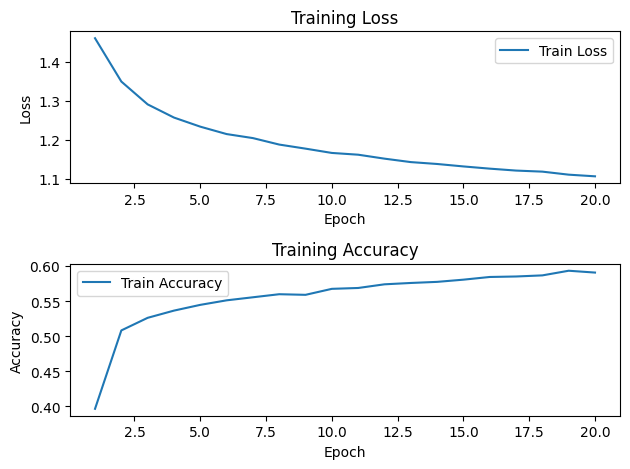

In [42]:
plot_loss(save_path, name_plot, best_model_info)

flattened_size: 9216
Test Accuracy: 0.5678
Classification Report:
               precision    recall  f1-score   support

           0       0.18      0.35      0.24       133
           1       0.49      0.50      0.49       406
           2       0.25      0.70      0.37       275
           3       0.85      0.59      0.70      1896
           4       0.00      0.00      0.00        39

    accuracy                           0.57      2749
   macro avg       0.35      0.43      0.36      2749
weighted avg       0.70      0.57      0.60      2749



c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

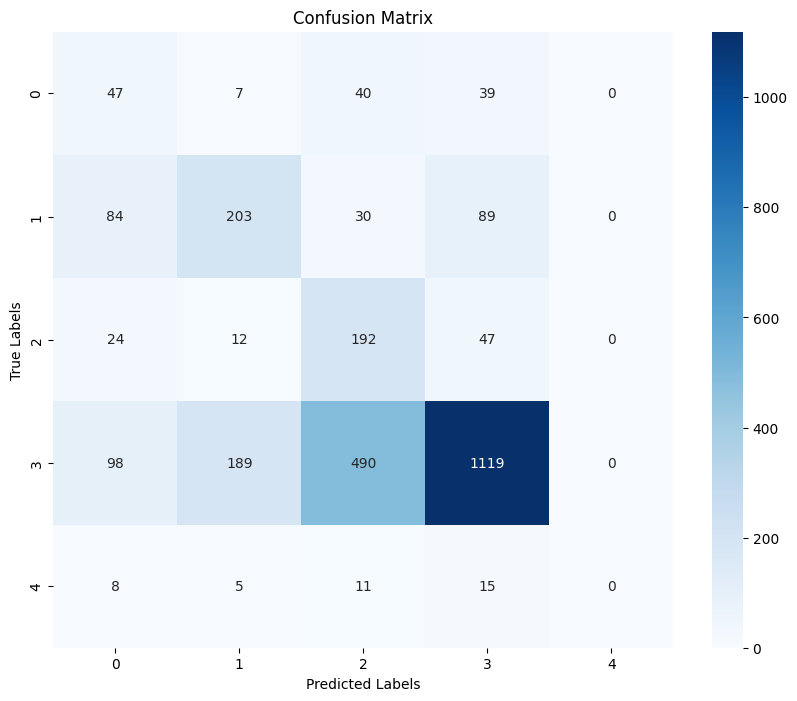

In [43]:
model_path = "SAVE/PREPROCESSED/2_CNN.pth"
model = create_deep_cnn_model()
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
accuracy, report = test_model(model, model_path, test_loader, device, show=True)